<center><b> Analyzing YouTube Comments on Deepfake Videos to Understand Audience Reactions and Opinions </b></center>
<center>Carol Shao</center>
<center>DH 101</center>
<center>Prof. Sharma</center>

# Introduction

In recent years, the fast progress of artificial intelligence (AI) and machine learning has led to a new type of media manipulation called deepfakes. Deepfakes are videos changed by AI to replace a person’s face with someone else’s, creating very realistic footage that can be hard to tell apart from real videos. This technology has caught the attention of researchers, the media, and the public due to its potential for misuse, such as spreading false information, swaying public opinion, or creating non-consensual pornographic content. As deepfakes become more advanced and easier to access, it is important to understand how people view and interact with this technology. The social impact of deepfakes goes beyond the technical side of making and spotting them, as they can influence public conversation, shape opinions, and weaken trust in media and institutions. Thus, studying public attitudes and reactions to deepfakes is key to developing effective strategies to lessen their negative effects and boost media literacy in the digital age.

YouTube, a major video-sharing platform, offers a wealth of data to explore audience reactions and opinions on deepfake videos. With billions of active users each month and a wide range of content, YouTube has become a central place for discussions on various topics, including deepfakes. The platform’s comment section lets users share their thoughts, opinions, and reactions to the videos they watch, creating a valuable record of public sentiment and discourse. By examining YouTube comments, this project aims to address a gap in current deepfake research, which has mainly focused on the technical side of their creation and detection, as well as legal and ethical issues. While these areas are important, understanding how the general public views and interacts with deepfakes on social media is just as crucial for gaining a full understanding of the social aspects of this technology.


The specific research question for this project is: What are the main themes, sentiments, and opinions found in YouTube comments on deepfake videos, and how do they reflect public views and attitudes towards deepfakes? While past studies have looked into the technical details and possible misuse of deepfakes, there is not much research on how the general public interacts with and talks about this technology on social media. By focusing on YouTube comments, this project takes a new approach to understanding the social aspects of deepfakes from the audience’s perspective.


In [95]:
import re
import spacy
import string
import math
import random
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import nltk 
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from string import punctuation
from collections import Counter
nltk.download('wordnet')
nltk.download('punkt') 

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from IPython.core.display import Image, display
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

mpl.rc('savefig', dpi=200)
plt.style.use('fivethirtyeight')
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.minor.size'] = 1
sns.set(style = "whitegrid", color_codes = True, font_scale = 1.5)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/carolshao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/carolshao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/var/folders/0z/4pqw_cvn3996j72ldn8vn9d80000gn/T/ipykernel_1414/2260742495.py:23: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


# Data Extraction

I extracted my data from Youtube comments using the Youtube API. All the scripts are saved in data_generator.py. The extracted data are saved in youtube_comments_politics.csv and youtube_comments_celebrity.csv. 

In [96]:
file_celebrity = 'youtube_comments_celebrity.csv'
file_politics = 'youtube_comments_politics.csv'

# Load the CSV files
comments_celebrity = pd.read_csv(file_celebrity)
comments_politics = pd.read_csv(file_politics)

# Combine comments into a single string for each file
combined_celebrity_comments = " ".join(comments_celebrity['comment'])
combined_politics_comments = " ".join(comments_politics['comment'])

# Create a DataFrame with the combined comments
data = {
    'file_name': ['youtube_comments_celebrity.csv', 'youtube_comments_politics.csv'],
    'combined_comments': [combined_celebrity_comments, combined_politics_comments]
}

df_combined_comments = pd.DataFrame(data)

# Display the DataFrame
df_combined_comments

,file_name,combined_comments
0,youtube_comments_celebrity.csv,What if He plays as joker? this is your safe s...
1,youtube_comments_politics.csv,"Although, I wouldn't mind hearing Obama saying..."


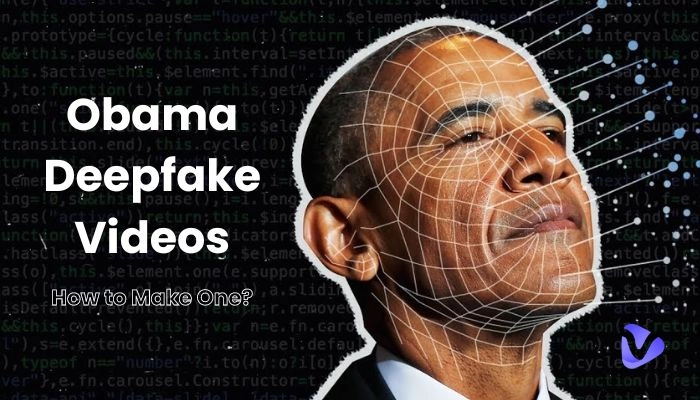

In [97]:
display(Image("header_image.jpeg", width=800, unconfined=True))

# Polarity Analysis

For this part of the project, I am using Vader (Valence Aware Dictionary for Entiment Reasoning). 

In [98]:
analyzer = SentimentIntensityAnalyzer()

def get_polarity_score(text):
    return analyzer.polarity_scores(text)

celebrity_sentiment = get_polarity_score(combined_celebrity_comments)
politics_sentiment = get_polarity_score(combined_politics_comments)

data = {
    'file_name': ['youtube_comments_celebrity.csv', 'youtube_comments_politics.csv'],
    'combined_comments': [combined_celebrity_comments, combined_politics_comments],
    'neg': [celebrity_sentiment['neg'], politics_sentiment['neg']],
    'neu': [celebrity_sentiment['neu'], politics_sentiment['neu']],
    'pos': [celebrity_sentiment['pos'], politics_sentiment['pos']],
    'compound': [celebrity_sentiment['compound'], politics_sentiment['compound']]
}

df_combined_comments = pd.DataFrame(data)
df_combined_comments

,file_name,combined_comments,neg,neu,pos,compound
0,youtube_comments_celebrity.csv,What if He plays as joker? this is your safe s...,0.108,0.662,0.230,0.9999
1,youtube_comments_politics.csv,"Although, I wouldn't mind hearing Obama saying...",0.166,0.587,0.247,1.0000


<b>The sentiment analysis results indicate that both videos display a very positive overall sentiment (compound score almost equal to 1). The politics-related comments seems to be slightly higher than that of the celebrity video. </b>

# Text Processing

In [99]:
combined_celebrity_comments = " ".join(comments_celebrity['comment'].astype(str))
combined_politics_comments = " ".join(comments_politics['comment'].astype(str))

stop_words = set(stopwords.words('english'))

def tokenize_and_filter(text):
    words = word_tokenize(text)
    filtered_words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    return filtered_words

celebrity_words = tokenize_and_filter(combined_celebrity_comments)
politics_words = tokenize_and_filter(combined_politics_comments)

analyzer = SentimentIntensityAnalyzer()

def sentiment_words(words):
    sentiment_words = [word for word in words if analyzer.polarity_scores(word)['compound'] != 0]
    return sentiment_words

celebrity_sentiment_words = sentiment_words(celebrity_words)
politics_sentiment_words = sentiment_words(politics_words)
celebrity_common_words = Counter(celebrity_sentiment_words).most_common(10)
politics_common_words = Counter(politics_sentiment_words).most_common(10)
df_celebrity_common = pd.DataFrame(celebrity_common_words, columns=['word', 'count'])
df_politics_common = pd.DataFrame(politics_common_words, columns=['word', 'count'])


# Statistical Analysis

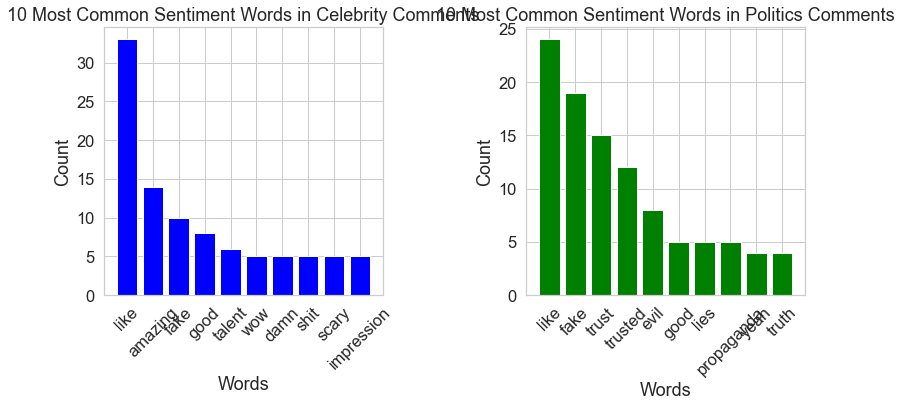

In [100]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(df_celebrity_common['word'], df_celebrity_common['count'], color='blue')
plt.title('10 Most Common Sentiment Words in Celebrity Comments')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
plt.bar(df_politics_common['word'], df_politics_common['count'], color='green')
plt.title('10 Most Common Sentiment Words in Politics Comments')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analysis of Most Common Sentiment Words in YouTube Comments

The bar graphs display the 10 most common sentiment words found in the comments of two different categories: celebrity-related videos and politics-related videos.

In the comments on celebrity-related videos, commonly used words such as "amazing", "good", "talent", "wow", and "impression" indicate positive sentiment. These words suggest that viewers generally have a favorable reaction to celebrity-related content. There are also a few negative sentiment words like "fake", "damn", and "scary", but these are less frequent compared to the positive words, reinforcing the notion of an overall positive audience perception.

In the comments on politics-related videos, the prominent presence of negative sentiment words such as "fake", "evil", "lies", "propaganda", and "trust" (when used in a negative context) suggests a more critical or skeptical attitude towards politics-related content. Fewer positive words appear in this category, with "trusted" and "good" being notable exceptions. This indicates that the overall sentiment in the politics comments is more mixed or negative compared to the celebrity comments.

In both videos, the word "like" appears most frequently. However, this high frequency might not accurately reflect sentiment, as "like" can often be used in different contexts, not necessarily as an expression of sentiment. In the previous analysis, the politics video's comments received a higher positive score. This may be due to the mis-classification of "like". I will run the script excluding like to see if it makes any difference on the sentiment evaluation score. 

# Polarity Analysis After Removing "like"


In [101]:
stop_words.add("like")

def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    return " ".join(filtered_words)

filtered_celebrity_comments = remove_stopwords(combined_celebrity_comments)
filtered_politics_comments = remove_stopwords(combined_politics_comments)

celebrity_sentiment = get_polarity_score(filtered_celebrity_comments)
politics_sentiment = get_polarity_score(filtered_politics_comments)

data = {
    'file_name': ['youtube_comments_celebrity.csv', 'youtube_comments_politics.csv'],
    'filtered_comments': [filtered_celebrity_comments, filtered_politics_comments],
    'neg': [celebrity_sentiment['neg'], politics_sentiment['neg']],
    'neu': [celebrity_sentiment['neu'], politics_sentiment['neu']],
    'pos': [celebrity_sentiment['pos'], politics_sentiment['pos']],
    'compound': [celebrity_sentiment['compound'], politics_sentiment['compound']]
}

df_filtered_comments_polarity = pd.DataFrame(data)
df_filtered_comments_polarity

,file_name,filtered_comments,neg,neu,pos,compound
0,youtube_comments_celebrity.csv,plays joker safe spot friend may trppin yes fa...,0.142,0.622,0.237,0.9994
1,youtube_comments_politics.csv,although would mind hearing obama saying last ...,0.189,0.603,0.208,0.9773


Removing the word “like” from the comments resulted in a slight increase in negative sentiment score and a decrease in neutral sentiment score for both celebrity-related and politics-related comments. The positive sentiment score increased for the celebrity-related video but decreased for the politics-related video. Now, the celebrity video displays a higher positive score than the politics video's comments, which is consistent with the results in the statistical analysis of the common sentiment words occurring in the comments - the overall sentiment in the politics comments is more mixed or negative compared to the celebrity comments.

# Top 10 Sentiment Words After Removing "like"

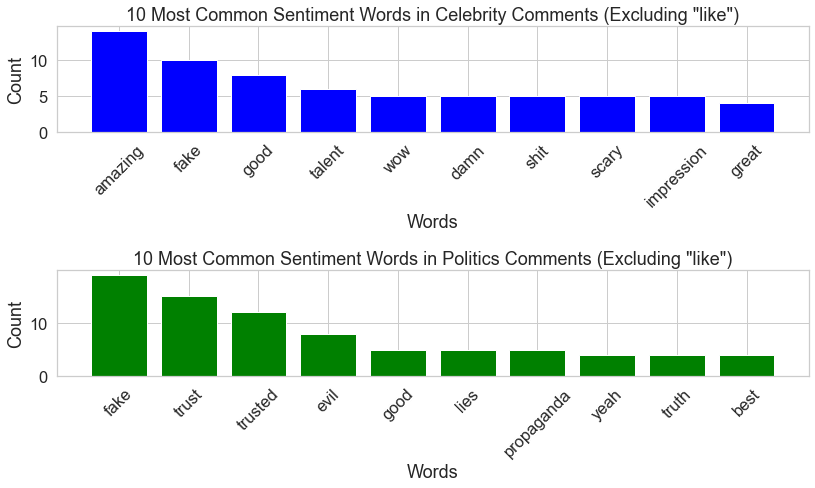

In [102]:
celebrity_words = tokenize_and_filter(combined_celebrity_comments)
politics_words = tokenize_and_filter(combined_politics_comments)

celebrity_sentiment_words = sentiment_words(celebrity_words)
politics_sentiment_words = sentiment_words(politics_words)
celebrity_common_words = Counter(celebrity_sentiment_words).most_common(10)
politics_common_words = Counter(politics_sentiment_words).most_common(10)
df_celebrity_common = pd.DataFrame(celebrity_common_words, columns=['word', 'count'])
df_politics_common = pd.DataFrame(politics_common_words, columns=['word', 'count'])

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.bar(df_celebrity_common['word'], df_celebrity_common['count'], color='blue')
plt.title('10 Most Common Sentiment Words in Celebrity Comments (Excluding "like")')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.subplot(2, 1, 2)
plt.bar(df_politics_common['word'], df_politics_common['count'], color='green')
plt.title('10 Most Common Sentiment Words in Politics Comments (Excluding "like")')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplots_adjust(hspace=1.3)
plt.show()

# Top 5 Most Polarized Comments for Each Video

In [103]:
def sentence_compound_score(sentence_str):
    return analyzer.polarity_scores(sentence_str)["compound"]

def avg_sentiment_rating(raw_text_str):
    return (pd.Series(sent_tokenize(raw_text_str)).apply(sentence_sentiment_score).mean())

def most_polarized_sentence(raw_text_str, negative=False):
    sentences_ser = pd.Series(sent_tokenize(raw_text_str))
    sentiment_ratings = sentences_ser.apply(sentence_compound_score)
    zipped = list(zip(sentiment_ratings.index, sentiment_ratings))
    if negative:
        most_pos_tup = min(zipped, key=lambda x: x[1])
    else:
        most_pos_tup = max(zipped, key=lambda x: x[1])
    most_pos_sent = sentences_ser[most_pos_tup[0]]
    return most_pos_sent.replace("\n", " ")

comments_celebrity['polarity'] = comments_celebrity['comment'].apply(lambda x: sentence_sentiment_score(str(x)))
comments_politics['polarity'] = comments_politics['comment'].apply(lambda x: sentence_sentiment_score(str(x)))
comments_celebrity['abs_polarity'] = 0.0
comments_politics['abs_polarity'] = 0.0
for i in range(len(comments_celebrity)):
    comments_celebrity.at[i, 'abs_polarity'] = abs(comments_celebrity.at[i, 'polarity'])
for i in range(len(comments_politics)):
    comments_politics.at[i, 'abs_polarity'] = abs(comments_politics.at[i, 'polarity'])
top_polarized_celebrity = comments_celebrity.sort_values(by='abs_polarity', ascending=False).head(5)
top_polarized_politics = comments_politics.sort_values(by='abs_polarity', ascending=False).head(5)


print("Top 5 Polarized Celebrity Comments")
print(top_polarized_celebrity[['comment', 'polarity']])
print("\nTop 5 Polarized Politics Comments")
print(top_polarized_politics[['comment', 'polarity']])

Top 5 Polarized Celebrity Comments
                                               comment  polarity
131  Tom is a fan of movies, that's why he can say ...    0.9768
69   You're Tom Cruise !!!!!!!!!!!!!!!!!!!!!!!!!!!!...    0.9737
47                                              😂😅😅😂😅😂    0.9349
179  That is so awesome 👌 I just took a couple of h...    0.9275
125  Bill Hader was so giggly and adorable telling ...    0.9227

Top 5 Polarized Politics Comments
                                               comment  polarity
176  This is why I always watch CNN!!! 😂😂😂😂😂😂😂😂😂😂😂😂...    0.9999
114  Thanks Jordan Peel for your insight to our wes...    0.9753
177  And yes- this message brought to you by Jordan...    0.9409
175  "Trusted news sources"... like CNN 🤣😂🤣 "STAY W...    0.9313
70   Advocating for ethical guidelines within the t...    0.9042


# Topic Modeling Using LDA

Celebrity Comments Topics:
Top words for topic #0: ['tom', 'cruise', 'like']
Top words for topic #1: ['deep', 'fake', 'hader']
Top words for topic #2: ['tom', 'just', 'face']
Top words for topic #3: ['creepy', 'change', 'face']
Top words for topic #4: ['bro', 'crazy', 'amazing']


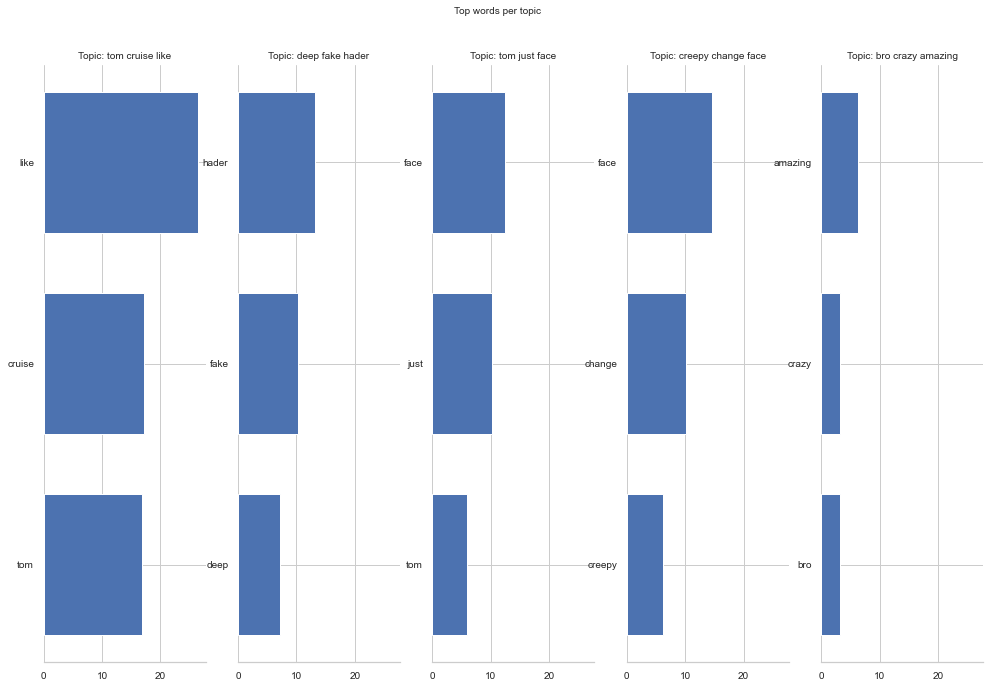


Politics Comments Topics:
Top words for topic #0: ['obama', 'like', 'ai']
Top words for topic #1: ['man', 'real', 'obama']
Top words for topic #2: ['sources', 'trusted', 'news']
Top words for topic #3: ['fake', 'deepfake', 'deep']
Top words for topic #4: ['obama', 'trust', 'fake']


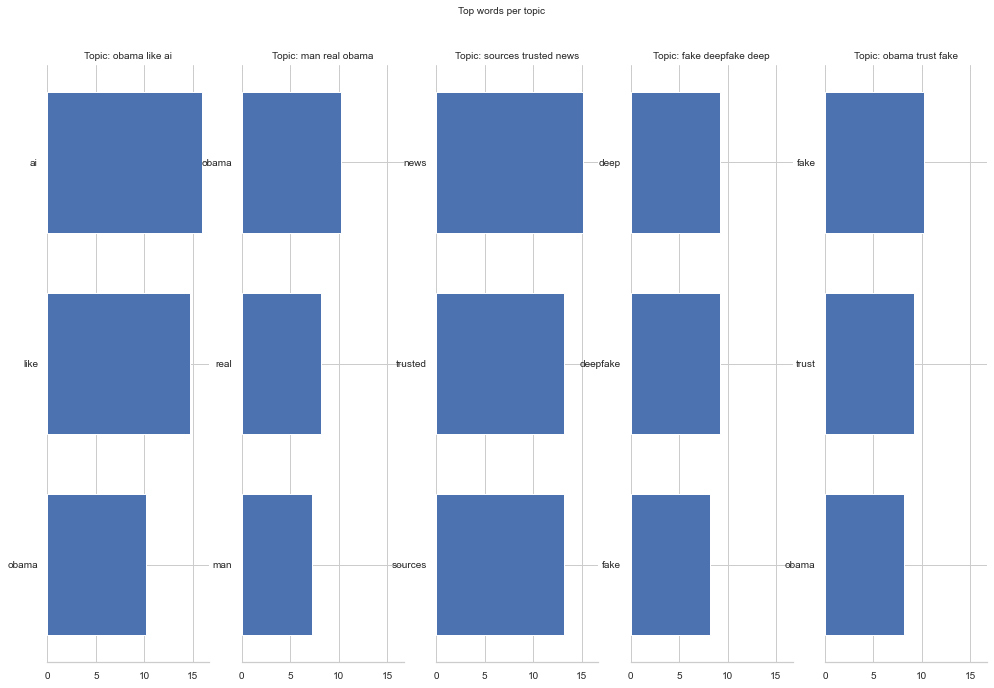

In [107]:
def perform_lda(comments, n_topics=5):
    # Vectorize the text data
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(comments)

    # Apply LDA
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(dtm)

    # Generate names for each topic based on the top words
    topic_names = []
    n_top_words = 3  # Number of top words to use for naming
    for index, topic in enumerate(lda.components_):
        top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-n_top_words:]]
        topic_name = " ".join(top_words)
        topic_names.append(topic_name)
        print(f'Top words for topic #{index}: {top_words}')

    # Plot the topics with generated names
    fig, axes = plt.subplots(1, n_topics, figsize=(15, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(lda.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [vectorizer.get_feature_names_out()[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic: {topic_names[topic_idx]}', fontdict={'fontsize': 10})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=10)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
    fig.suptitle('Top words per topic', fontsize=10)
    plt.subplots_adjust(top=0.90, hspace=0.3)
    plt.show()

# Perform LDA on each CSV file
print("Celebrity Comments Topics:")
perform_lda(comments_celebrity['comment'])

print("\nPolitics Comments Topics:")
perform_lda(comments_politics['comment'])

**Celebrity Deepfakes**:
The main themes in the comments about celebrity deepfakes revolve around specific personalities such as Tom Cruise and Bill Hader, the visual quality of the deepfakes, and the emotional reactions from viewers. There is a clear mix of fascination and discomfort, with some viewers expressing excitement and amazement at the technology, while others find it creepy and unsettling. This suggests that while the audience enjoys the entertainment value, there is an underlying recognition of the eerie realism that deepfakes can achieve.

**Political Deepfakes**:
In contrast, discussions about political deepfakes are more focused on the implications of the technology for public trust and information authenticity. Comments frequently mention terms like “sources,” “trusted,” and “news,” indicating a significant concern about the potential for misinformation and the impact on public figures like Barack Obama. There is a clear recognition of the potential for deepfakes to deceive and mislead, which could undermine the credibility of public figures and the media.

By analyzing these themes, it becomes evident that while deepfake technology is often viewed with curiosity and excitement in the context of entertainment, it raises significant ethical and trust-related concerns when it intersects with politics. This dual perception underscores the need for careful consideration of the implications of deepfake technology across different domains.

# Sentiment Trends Over Time

/Users/carolshao/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/Users/carolshao/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


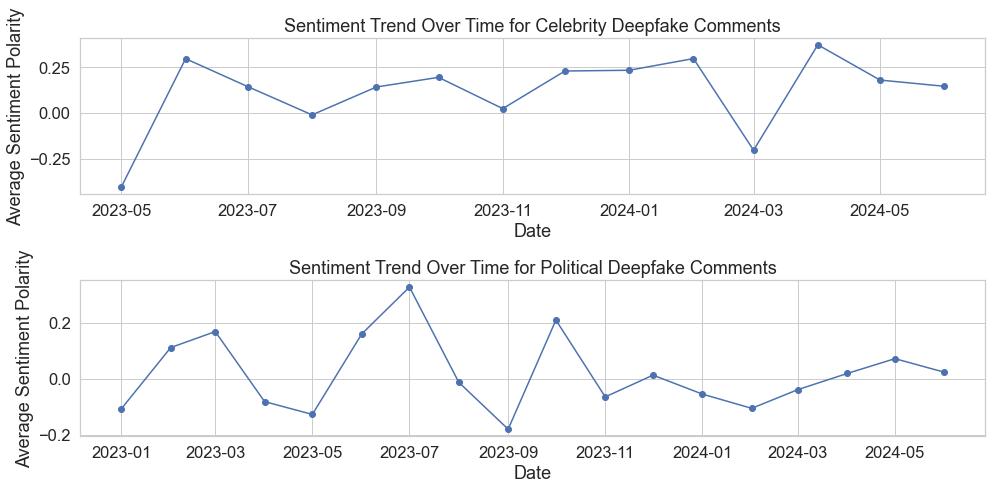

In [109]:
comments_celebrity['date'] = pd.to_datetime(comments_celebrity['date'])
comments_politics['date'] = pd.to_datetime(comments_politics['date'])

comments_celebrity['polarity'] = comments_celebrity['comment'].apply(sentence_compound_score)
comments_politics['polarity'] = comments_politics['comment'].apply(sentence_compound_score)

celebrity_sentiment_trend = comments_celebrity.groupby(comments_celebrity['date'].dt.to_period('M')).mean().reset_index()
politics_sentiment_trend = comments_politics.groupby(comments_politics['date'].dt.to_period('M')).mean().reset_index()

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(celebrity_sentiment_trend['date'].dt.to_timestamp(), celebrity_sentiment_trend['polarity'], marker='o', linestyle='-')
plt.title('Sentiment Trend Over Time for Celebrity Deepfake Comments')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Polarity')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(politics_sentiment_trend['date'].dt.to_timestamp(), politics_sentiment_trend['polarity'], marker='o', linestyle='-')
plt.title('Sentiment Trend Over Time for Political Deepfake Comments')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Polarity')
plt.grid(True)

plt.tight_layout()
plt.show()

### Celebrity Deepfake Comments
The sentiment trend over time for celebrity deepfake comments shows some fluctuations, but overall, the sentiment remains mostly positive or neutral. Notably, there are significant peaks in positive sentiment around May 2023 and January 2024. These peaks suggest that during these periods, viewers' comments were generally more positive, possibly due to the release of particularly well-received deepfake videos or favorable public reactions to certain celebrity deepfakes. Conversely, the sentiment dips to neutral or slightly negative levels around March 2024, which could indicate a period where the deepfake videos did not impress viewers as much, or there might have been some controversies or negative reactions. Despite these fluctuations, the average sentiment remains slightly positive, indicating that viewers tend to have a favorable view of celebrity deepfakes overall.

### Political Deepfake Comments
The sentiment trend over time for political deepfake comments displays more volatility and lower overall sentiment compared to celebrity deepfake comments. Early in the period, around January 2023, there is a positive sentiment which quickly rises to a peak in March 2023. This initial positivity might reflect curiosity or interest in the new technology applied to political figures. However, the sentiment fluctuates significantly throughout the observed period, with sharp declines to negative sentiment around July 2023 and September 2023, followed by partial recoveries. This volatility suggests mixed reactions from viewers, with periods of significant concern or disapproval. This volatility may be related with the election. 

# Conclusion

Overall, while deepfake technology is often viewed with curiosity and excitement in the context of entertainment, it raises significant ethical and trust-related concerns when it intersects with politics. This dual perception underscores the need for careful consideration of the implications of deepfake technology in different domains.

Through this project, I also gained valuable experiences in basic text analysis skills. 